# Testing automatic fiducial finding

We want to automatically find fiducials and spit out an ANC file for work with peak selector

In [1]:
%matplotlib notebook
import numpy as np
%load_ext autoreload
%autoreload 2
import palm_utils as pu
from peaks.peakfinder import PeakFinder

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, PowerNorm

In [3]:
data = pu.PALMData("Run1_532_Part1_10k_IDL.sav")

Reading Run1_532_Part1_10k_IDL.sav into memory ... 
--------------------------------------------------
Date: Mon Aug  7 20:39:27 2017
User: hoffmand
Host: h11u19.int.janelia.org
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.5.1
--------------------------------------------------
Successfully read 30 records of which:
 - 1 are of type VERSION
 - 27 are of type VARIABLE
 - 1 are of type TIMESTAMP
--------------------------------------------------
Available variables:
 - cgrpsize [<class 'numpy.int64'>]
 - wind_range [<class 'numpy.float32'>]
 - fiducialcoeff [<class 'numpy.recarray'>]
 - savfilenames [<class 'bytes'>]
 - rownames [<class 'numpy.ndarray'>]
 - totalrawdata [<class 'numpy.ndarray'>]
 - rawfilenames [<class 'numpy.ndarray'>]
 - paramlimits [<class 'numpy.ndarray'>]
 - nmperframe [<class 'numpy.float32'>]
 - guidestardrift [<class 'numpy.recarray'>]
 - lambda_vac [<class 'numpy.float32'>]
 - z_unwrap_c

In [16]:
import scipy.ndimage as ndi

In [28]:
def labels_to_ranges(labeled_img, edges):
    """Takes a labeled image and returns ranges"""
    objs = ndi.find_objects(labeled_img)
    ranges = []
    for obj in objs:
        ranges.append([edge[o.start:o.stop + 1] for o, edge in zip(obj, edges)])
    return ranges

def find_fiducials(df, yx_shape, subsampling=1, thresh=None):
    """Find fiducials in pointilist PALM data
    
    The key here is to realize that there should be on fiducial per frame"""
    # incase we subsample the frame number
    num_frames = df.framenum.max() - df.framenum.min()
    # we want the bins to be centered around a given pixel.
    bins = [np.arange(s + subsampling, step=subsampling) - subsampling / 2 for s in yx_shape]
    # ungrouped 2d histogram to find peaks, ungrouped to make beads really stand out
    hist2d, edges = np.histogramdd(df[["ypos", "xpos"]].values, bins=bins)
    # threshold and find localmaxima
    if thresh is None:
        thresh = num_frames
    for thresh in np.linspace(0, thresh, 10)[::-1]:
        fiducial_locations = hist2d > thresh
        if fiducial_locations.sum():
            break
    return labels_to_ranges(ndi.label(fiducial_locations)[0], edges)

In [30]:
junk = find_fiducials(data.processed, (832,)*2)

In [31]:
junk

[[array([ 2.5,  3.5], dtype=float32), array([ 119.5,  120.5], dtype=float32)],
 [array([ 20.5,  21.5], dtype=float32),
  array([ 213.5,  214.5], dtype=float32)],
 [array([ 39.5,  40.5], dtype=float32),
  array([ 518.5,  519.5], dtype=float32)],
 [array([ 46.5,  47.5], dtype=float32),
  array([ 301.5,  302.5], dtype=float32)],
 [array([ 151.5,  152.5], dtype=float32),
  array([ 425.5,  426.5], dtype=float32)],
 [array([ 157.5,  158.5], dtype=float32),
  array([ 276.5,  277.5], dtype=float32)],
 [array([ 198.5,  199.5], dtype=float32),
  array([ 111.5,  112.5], dtype=float32)],
 [array([ 210.5,  211.5], dtype=float32),
  array([ 366.5,  367.5], dtype=float32)],
 [array([ 242.5,  243.5], dtype=float32),
  array([ 176.5,  177.5], dtype=float32)],
 [array([ 245.5,  246.5], dtype=float32),
  array([ 548.5,  549.5], dtype=float32)],
 [array([ 258.5,  259.5], dtype=float32),
  array([ 19.5,  20.5], dtype=float32)],
 [array([ 266.5,  267.5], dtype=float32),
  array([ 255.5,  256.5], dtype=float

# Refining

We can see that we pick too many fiducials above, we should drift correct and then test again

In [35]:
import pandas as pd
import tqdm

In [36]:
def remove_xy_mean(df):
    df_mean = df[["ypos", "xpos"]].astype(np.float).mean()
    df_new = df.copy()
    df_new[["ypos", "xpos"]] -= df_mean
    return df_new

def calc_drift(fiducials_df, weighted="amp", diagnostics=False):
    """"""
    mean_removed = [remove_xy_mean(ff) for ff in fiducials_df]
    if diagnostics:
        fig, (ax0, ax1) = plt.subplots(1, 2)
        for ff in mean_removed:
            ff.xpos.plot(ax=ax0)
            ff.ypos.plot(ax=ax1)
            
    # want to do a weighted average
    # need to reset_index after concatination so that all localzations have unique ID
    df_means = pd.concat(mean_removed).reset_index()

    # Define a dictionary with the functions to apply for a given column:
    if weighted:
        wm = lambda group: np.average(group, weights=df_means.loc[group.index, weighted])
    else:
        wm = "mean"
    return df_means.groupby("framenum").agg({"xpos" : wm, "ypos" : wm})

In [46]:
def calc_fiducial_stats(fid_df_list):
    """Calculate various stats"""
    fwhm = lambda x: x.std() * 2 * np.sqrt(2 * np.log(2))
    fid_stats = pd.DataFrame([f[["xpos", "ypos", "amp"]].mean() for f in fid_df_list])
    fid_stats[["xdrift", "ydrift"]] = pd.DataFrame([f.agg({"xpos":fwhm,"ypos":fwhm}) for
                                                    f in fid_df_list])
    fid_stats["sigma"] = np.sqrt(fid_stats.ydrift**2 + fid_stats.xdrift**2)
    all_drift = pd.concat([f[["xpos","ypos"]] - f[["xpos","ypos"]].mean() for f in fid_df_list])
    return fid_stats, all_drift

def extract_fiducials(df, ranges, min_num_frames=0):
    """Do the actual filtering
    
    We're doing it sequentially because we may run out of memory.
    If initial DataFrame is 18 GB (1 GB per column) and we have 200 """
    fiducials_dfs = [df[(xmin < df.xpos) & (df.xpos < xmax) & (ymin < df.ypos) & (df.ypos < ymax)]
        for (ymin, ymax), (xmin, xmax) in tqdm.tqdm_notebook(ranges, leave=False, desc="Extracting Fiducials")]
    # remove any duplicates in a given frame by only keeping the localization with the largest count
    clean_fiducials = [sub_df.sort_values('amp', ascending=False).groupby('framenum').first()
                       for sub_df in fiducials_dfs if len(sub_df) > min_num_frames]
    return clean_fiducials

In [48]:
jj = extract_fiducials(data.processed, junk)

<IPython.core.display.Javascript object>


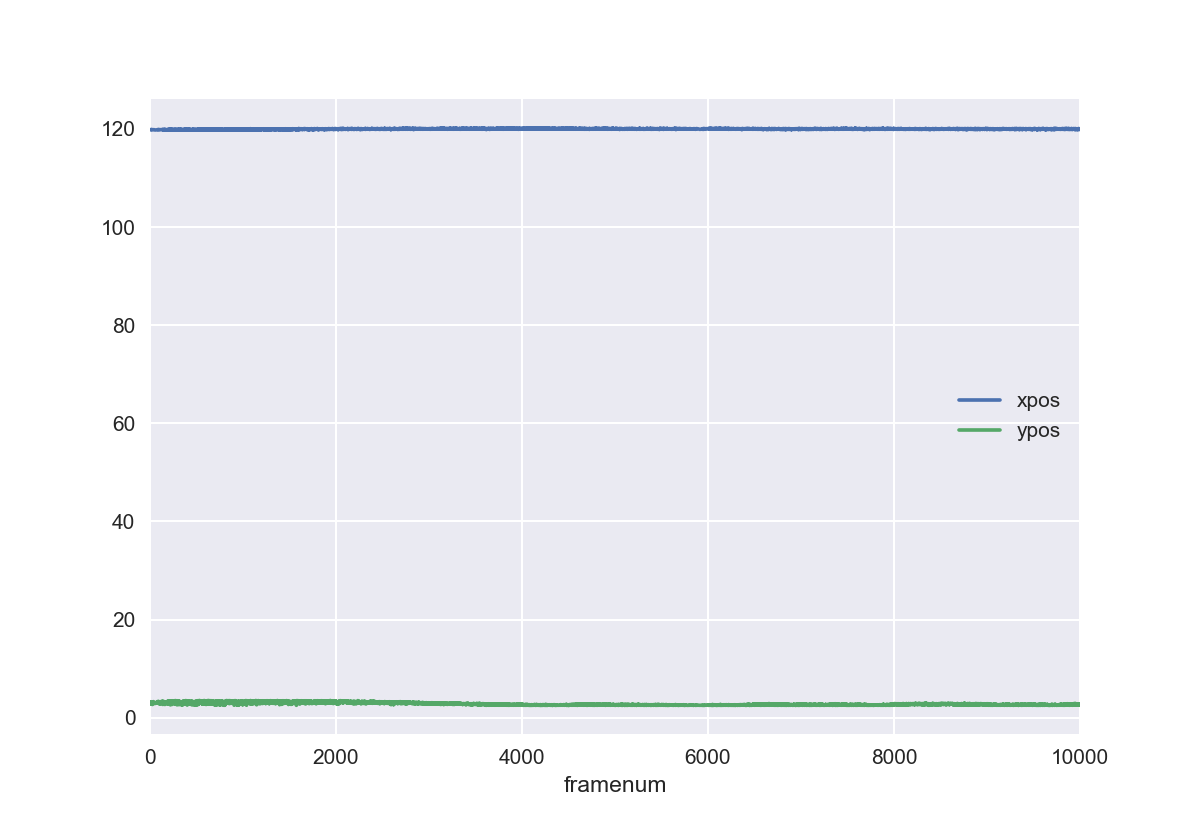

In [50]:
jj[0][["xpos","ypos"]].plot()